In [45]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
% matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter

% matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import explained_variance_score
from sklearn.model_selection import LeaveOneOut, KFold

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [2]:
def h5_save(path, data_obj, dts):
    if len(data_obj) != len(dts):
        print("something is wrong")
        return None
    with h5py.File(path, "w") as data_store:
        for idx, (key, val) in enumerate(data_obj.items()):
            data_set = data_store.create_dataset(
                key, val.shape, dtype=dts[idx]
            )
            data_set[...] = val
    return path, data_obj.keys()
    
def h5_read(path, key):
    with h5py.File(path, "r") as file_store:
        data = file_store[key][...]
    return data

In [3]:
ls

3dbrainviz.ipynb                      oldk_vs_adult/
RFCUSTOM.py                           oos_roc_rf.txt
Untitled.ipynb                        regional.ipynb
all_td_age.csv                        resh5py
alldata_rf_model.png                  results_with_nullmodel.h5py
behav.txt                             rf_featselect.ipynb
feature_per_iteration_inclusions.csv  rochist.png
fszstatcope2_means_all.csv            sklearn_prelim.ipynb
fszstatcope2_means_nz.csv             test_h5py
fszstatcope2_means_nz_valset.csv      valset_behav.csv
fszstatcope2_nvoxels_all.csv          yk_ad_results_with_nullmodel.h5py
fszstatcope2_nvoxels_nz.csv           yk_ok_results_with_nullmodel.h5py
fszstatcope2_nvoxels_nz_valset.csv    youngk_vs_adult/
git/                                  youngk_vs_oldk/
glm.ipynb


In [3]:
voxels = pd.read_csv("fszstatcope2_nvoxels_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == voxels.index)) #should be 1.0
voxels_g27 = voxels.iloc[:, (voxels.iloc[1,:] > 27).values]
remove_feature_idx = []

for idx, col in enumerate(voxels_g27.columns):
    for ss in ["Vent", "Stem", "Cerebellum", "CSF", "White", "plexus"]:
        if ss in col:
            remove_feature_idx.append(idx)
            
remove_feature_idx = np.unique(remove_feature_idx)
print(voxels_g27.shape[1] - remove_feature_idx.shape[0]) # should be 58
voxels_data = voxels_g27.iloc[:, np.setdiff1d(np.arange(voxels_g27.shape[1]), remove_feature_idx)]
roi_data = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0).loc[:, voxels_data.columns]
print(np.all(roi_data.columns == voxels_data.columns)) # should be true

# validation set
vset_roi_data = pd.read_csv("fszstatcope2_means_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vset_voxel_data = pd.read_csv("fszstatcope2_nvoxels_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vbehav = pd.read_csv("valset_behav.csv", index_col=0)

1.0
58
True


In [4]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

In [5]:
data = projection(roi_data, behav.loc[:, ["gender", "iq", "composite_motion"]])

In [11]:
behav.shape, data.shape

((76, 13), (76, 58))

In [6]:
y = behav.age.values
X = data.values

In [39]:
clf = Pipeline([
    ("scale", StandardScaler()),
    ("lm", linear_model.RidgeCV(
        cv=KFold(n_splits=10)
    ))
])

cv_out = LeaveOneOut()

res = {
    "r2":[],
    "ytrue":[],
    "pred":[]
}

In [40]:
for idx, (train, test) in enumerate(cv_out.split(X, y)):
    clf.fit(X[train], y[train])
    res["pred"].append(clf.predict(X[test]))
    res["ytrue"].append(y[test])
    

In [41]:
print(explained_variance_score(
    np.array(res["ytrue"]).ravel(),
    np.array(res["pred"]).ravel()
))


-1.0167326904631717
-1.0493401623574319


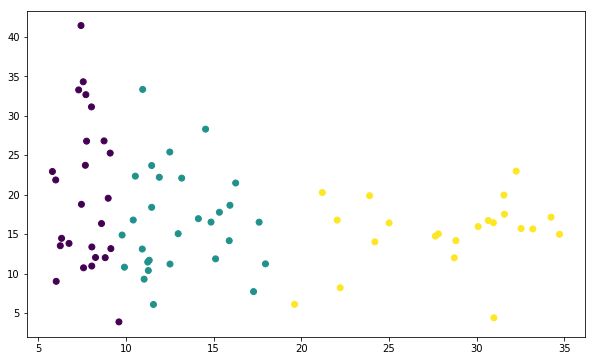

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(np.array(res["ytrue"]).ravel(), np.array(res["pred"]).ravel(), 
            c=behav.young_kid.values + behav.old_kid.values*2 + behav.adult.values*3)


# trying kernel ridge regression

In [161]:
kr = GridSearchCV(KernelRidge(kernel='laplacian', gamma=0.1), cv=6,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5],
                              "gamma": np.logspace(-2, 2, 5)})

res = {
    "r2":[],
    "ytrue":[],
    "pred":[]
}

sc = StandardScaler()

In [162]:
cv_out = LeaveOneOut()

In [163]:
for idx, (train, test) in enumerate(cv_out.split(X, y)):
    X_transform = sc.fit_transform(X[train], y[train])
    kr.fit(X_transform, y[train])
    res["pred"].append(kr.predict(sc.transform(X[test])))
    res["ytrue"].append(y[test])

Text(0,0.5,'predicted age')

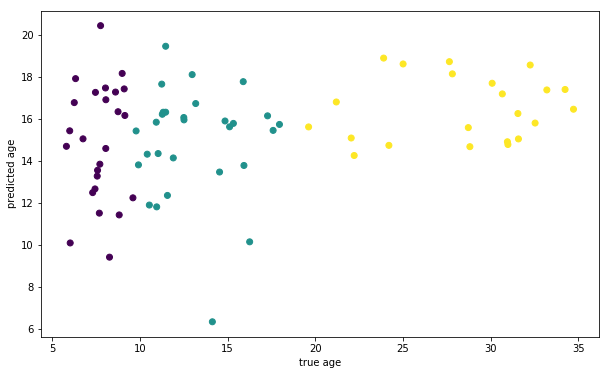

In [164]:
plt.figure(figsize=(10,6))
plt.scatter(
    np.array(res["ytrue"]).ravel(), np.array(res["pred"]).ravel(),
    c=behav.young_kid.values + behav.old_kid.values*2 + behav.adult.values*3
)
plt.xlabel("true age")
plt.ylabel("predicted age")

In [165]:
print(
    explained_variance_score(
        np.array(res["ytrue"]).ravel(),
        np.array(res["pred"]).ravel()
    )
)

0.07550152032567292
